In [ ]:
pip install gdal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import re
from osgeo import gdal

# Periksa Dataset

In [18]:
folder_path = '/content/drive/MyDrive/MCR_UNET/Dataset/251/'

# Mengecek pasangan file rgb dan ndwi
def check_mask_pairs(folder_path):
    file_names = set()
    mask_names = set()

    for file in os.listdir(folder_path):
        if file.endswith('.tif') and not file.endswith('_mask.tif'):
            file_name = os.path.splitext(file)[0]
            file_names.add(file_name)
        elif file.endswith('_mask.tif'):
            mask_name = os.path.splitext(file)[0].replace('_mask', '')
            mask_names.add(mask_name)

    all_have_pairs = True
    for file_name in file_names:
        if file_name not in mask_names:
            print(f"File {file_name}.tif tidak memiliki pasangan mask {file_name}_mask.tif")
            all_have_pairs = False

    for mask_name in mask_names:
        if mask_name not in file_names:
            print(f"Mask {mask_name}_mask.tif tidak memiliki pasangan file asli {mask_name}.tif")
            all_have_pairs = False

    if all_have_pairs:
        print("Semua citra memiliki pasangan NDWI")
    print("Pengecekan selesai.")

check_mask_pairs(folder_path)


File 0251_2020-07-02_MCR.tif tidak memiliki pasangan mask 0251_2020-07-02_MCR_mask.tif
Mask 0251_2020-07-02_mcr_mask.tif tidak memiliki pasangan file asli 0251_2020-07-02_mcr.tif
Pengecekan selesai.


# Menentukan Citra Target dan Referensi

In [19]:
# Menghiung cloud cover
def calculate_cloud_cover(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"tidak ada gambr {image_path}")
        return 100

    height, width, _ = img.shape
    total_pixels = height * width
    white_pixels = np.sum(img > 159)
    cloud_cover_percentage = (white_pixels / total_pixels) * 100
    return cloud_cover_percentage

# Cari citra dengan awan paling kecil
min_cloud_cover = 159
target_image = None

for file in os.listdir(folder_path):
    if file.endswith('.tif') and not file.endswith('_mask.tif'):
        file_path = os.path.join(folder_path, file)
        cloud_cover = calculate_cloud_cover(file_path)
        if cloud_cover < min_cloud_cover:
            min_cloud_cover = cloud_cover
            target_image = file_path

if target_image is None:
    raise Exception("Tidak ada citra yang ditemukan")

print(f"Citra target dengan awan paling kecil: {target_image} dengan cloud cover {min_cloud_cover:.2f}%")

target_image_dataset = gdal.Open(target_image)

reference_images = []
for file in os.listdir(folder_path):
    if file.endswith('.tif') and not file.endswith('_mask.tif'):
        file_path = os.path.join(folder_path, file)
        if file_path != target_image:
            reference_images.append(file_path)

reference_image_datasets = [gdal.Open(img) for img in reference_images]

print(f"Jumlah citra referensi: {len(reference_images)}")


Citra target dengan awan paling kecil: /content/drive/MyDrive/MCR_UNET/Dataset/251/0251_2020-07-02_MCR.tif dengan cloud cover 0.46%
Jumlah citra referensi: 5


In [21]:
# Menghitung cloud cover
def calculate_cloud_cover(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Tidak ada gambar {image_path}")
        return 100

    height, width, _ = img.shape
    total_pixels = height * width
    white_pixels = np.sum(np.all(img > 159, axis=2))
    cloud_cover_percentage = (white_pixels / total_pixels) * 100
    return cloud_cover_percentage

# Cari citra dengan cloud paling kecil
min_cloud_cover = 159
target_image = None

image_cloud_covers = []
for file in os.listdir(folder_path):
    if file.endswith('.tif') and not file.endswith('_mask.tif'):
        file_path = os.path.join(folder_path, file)
        cloud_cover = calculate_cloud_cover(file_path)
        image_cloud_covers.append((cloud_cover, file_path))
        if cloud_cover < min_cloud_cover:
            min_cloud_cover = cloud_cover
            target_image = file_path

if target_image is None:
    raise Exception("Tidak ada citra yang ditemukan")

print(f"Citra target dengan awan paling kecil: {target_image} dengan cloud cover {min_cloud_cover:.2f}%")

# Sorting citra referensi
sorted_images = sorted(image_cloud_covers, key=lambda x: x[0])
reference_images = [img_path for cloud_cover, img_path in sorted_images if img_path != target_image]
if not reference_images:
    raise Exception("Tidak ada citra referensi yang ditemukan")

target_image_dataset = gdal.Open(target_image)
reference_image_datasets = [gdal.Open(img) for img in reference_images]

print(f"Jumlah citra referensi: {len(reference_images)}")


Citra target dengan awan paling kecil: /content/drive/MyDrive/MCR_UNET/Dataset/251/0251_2020-07-02.tif dengan cloud cover 3.28%
Jumlah citra referensi: 4


# Cloud Masking

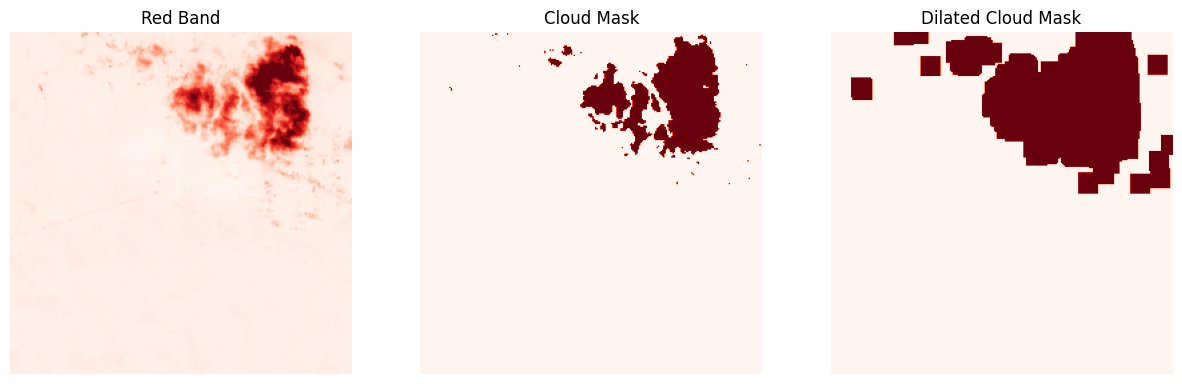

In [22]:
from osgeo import gdal
import matplotlib.pyplot as plt

def load_band(image_dataset, band_number):
    band = image_dataset.GetRasterBand(band_number)
    band_data = band.ReadAsArray()
    return band_data

# cloud masking band merah
def cloud_masking(image_path, threshold=80, kernel_size=15): #atur threshold band merah dan kernel untuk dilasi
    image_dataset = gdal.Open(image_path)
    red_band = load_band(image_dataset, 3)
    cloud_mask = red_band > threshold
    cloud_mask = cloud_mask.astype(np.uint8) * 255

    # Proses dilasi
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_cloud_mask = cv2.dilate(cloud_mask, kernel, iterations=1)

    return red_band, cloud_mask, dilated_cloud_mask

target_image_path = target_image
red_band, cloud_mask, dilated_cloud_mask = cloud_masking(target_image_path)

#show
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Red Band")
plt.imshow(red_band, cmap='Reds')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Cloud Mask")
plt.imshow(cloud_mask, cmap='Reds')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Dilated Cloud Mask")
plt.imshow(dilated_cloud_mask, cmap='Reds')
plt.axis('off')

plt.show()


# Pixel Mapping

Hasil citra dengan awan yang diganti telah disimpan di: /content/drive/MyDrive/MCR_UNET/Dataset/251/0251_2020-07-02_MCR.tif
Hasil mask yang dimodifikasi telah disimpan di: /content/drive/MyDrive/MCR_UNET/Dataset/251/0251_2020-07-02_mcr_mask.tif


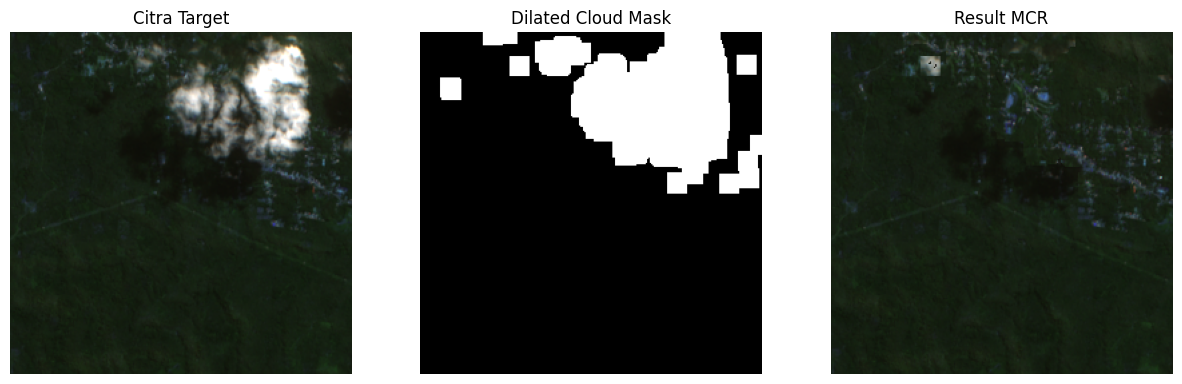

In [23]:
# Pixel Mapping
def replace_cloud_pixels(target_image_path, reference_image_paths, dilated_cloud_mask):
    target_dataset = gdal.Open(target_image_path)
    width = target_dataset.RasterXSize
    height = target_dataset.RasterYSize
    num_bands = target_dataset.RasterCount

    target_array = target_dataset.ReadAsArray()
    target_array = np.transpose(target_array, (1, 2, 0))
    reference_datasets = [gdal.Open(path) for path in reference_image_paths]

    # salinan array target dan cloud mask
    modified_array = np.copy(target_array)
    modified_mask = np.copy(dilated_cloud_mask)

    for y in range(height):
        for x in range(width):
            if dilated_cloud_mask[y, x] > 0:
                for ref_dataset in reference_datasets:
                    ref_array = ref_dataset.ReadAsArray()
                    ref_array = np.transpose(ref_array, (1, 2, 0))
                    if np.all(ref_array[y, x] <= 170):
                        modified_array[y, x] = ref_array[y, x]
                        modified_mask[y, x] = 0
                        break

    # Simpan hasil
    driver = gdal.GetDriverByName('GTiff')
    output_path = target_image_path.replace('.tif', '_MCR.tif')
    output_dataset = driver.Create(output_path, width, height, num_bands, gdal.GDT_Byte)
    output_dataset.SetGeoTransform(target_dataset.GetGeoTransform())
    output_dataset.SetProjection(target_dataset.GetProjection())

    for i in range(num_bands):
        output_dataset.GetRasterBand(i + 1).WriteArray(modified_array[:, :, i])

    print(f"Hasil citra dengan awan yang diganti telah disimpan di: {output_path}")

    mask_output_path = target_image_path.replace('.tif', '_mcr_mask.tif')
    mask_dataset = driver.Create(mask_output_path, width, height, 1, gdal.GDT_Byte)
    mask_dataset.SetGeoTransform(target_dataset.GetGeoTransform())
    mask_dataset.SetProjection(target_dataset.GetProjection())
    mask_dataset.GetRasterBand(1).WriteArray(modified_mask)
    mask_dataset = None
    print(f"Hasil mask yang dimodifikasi telah disimpan di: {mask_output_path}")

    return target_array, modified_array, dilated_cloud_mask, modified_mask

target_array, result_array, original_mask, modified_mask = replace_cloud_pixels(target_image, reference_images, dilated_cloud_mask)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Citra Target")
plt.imshow(target_array[:, :, [2,1,0]])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Dilated Cloud Mask")
plt.imshow(original_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Result MCR")
plt.imshow(result_array[:, :, [2,1,0]])
plt.axis('off')

plt.show()